# ABRF LMRG Segmentation

This notebook shows the steps I took to segment the image from the ABRF-LMRG Image Analysis Study.  Details about the study can be found here

https://sites.google.com/view/lmrg-image-analysis-study

## Open and show input

Open the input file with a special helper that open imagej tifs and reads and returns the spacings along with the image data.  Then show xyz maximum projections.

0.1238060147933331 0.1238060147933331 0.2


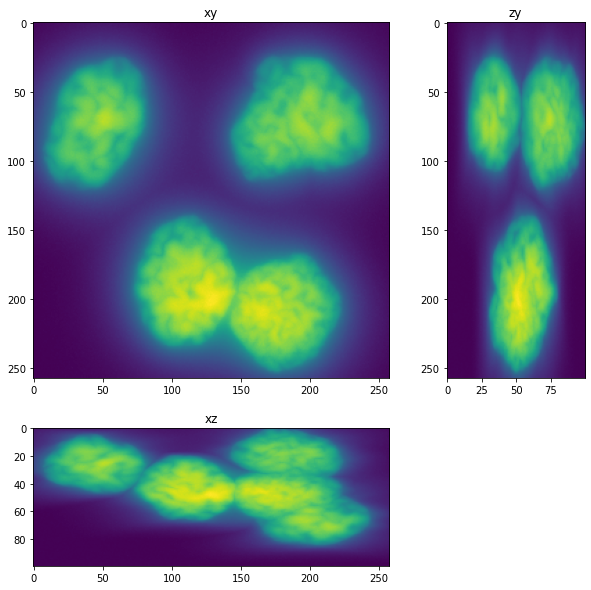

In [9]:
from tnia.io.tifffile_helper import open_ij3D
from tnia.plotting.projections import show_xyz_max

input_name="D:\\images\\ABRF LMRG Image Analysis Study\\nuclei\\nuclei1_out_c00_dr90_image.tif"

im_orig, sx, sy, sz = open_ij3D(input_name)
print(sx, sy, sz)
fig=show_xyz_max(im_orig)

## Create PSF and deconvolve

The image is a 3D Z-Stack Widefield fluorescence image, so deconvolution should help remove blur, increase contrast and lead to better segmentation and quantification.  One hiccup I had was that the data did not deconvolve well using the meta data provided (20x/0.75NA, Voxel dimensions: 0.124x0.124x0.200 um, Emission peak wavelength: 500 nm).  Instead I had to use a z voxel size much greater then the reported size (0.8 vs 0.2) to get good results.  I'm following up with the organizer about this and am trying to track down why the discrepency occurred.  

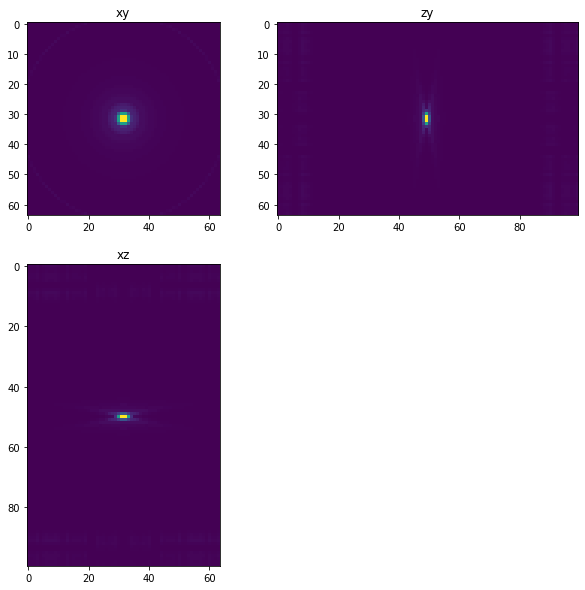

In [8]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.100
z_voxel_size=0.800

xy_psf_dim=64
z_psf_dim=100

NA=0.75
ni=1
ns=1

psf = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, 0, 0.45).astype('float32')
fig = show_xyz_max(psf)

get lib


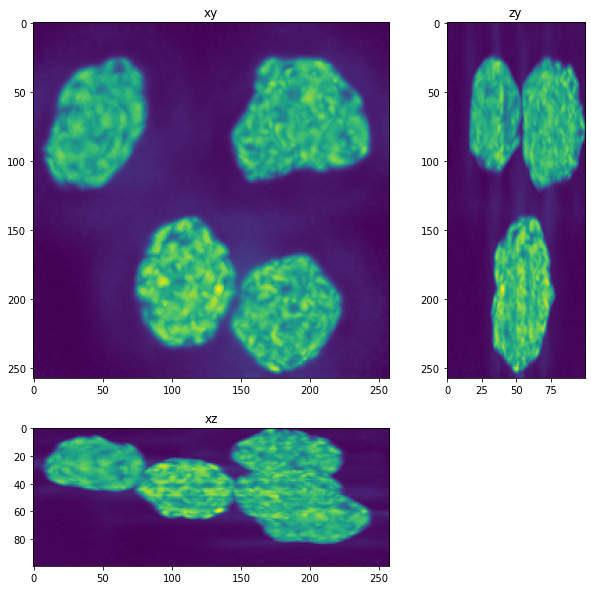

In [10]:
from clij2fft.richardson_lucy import richardson_lucy, richardson_lucy_nc
im_decon=richardson_lucy_nc(im_orig, psf, 200, 0)
fig=show_xyz_max(im_decon)

# Thresholding

Thresholding was done using a global Otsu threshold.  

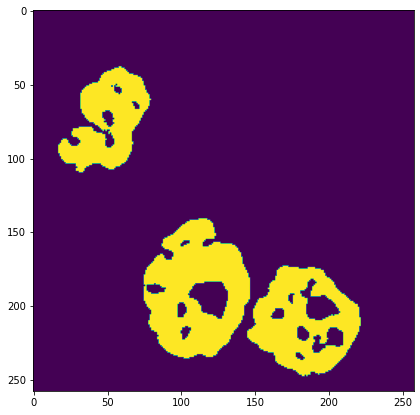

In [48]:
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# we resize here because downstream we will do watershed, and watershed tends to work better with isotropic voxels
resized= resize(im_decon, [int(sz*im_orig.shape[0]/sx),im_orig.shape[1], im_orig.shape[2]])

binary = resized>threshold_otsu(resized)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(binary[65,:,:])


## Binary Morphology

The thresholded result had many holes and 'tunnels' in it which could lead to over-splitting at the Watershed step.  Thus we use morphological operations to fill the holes.  In this case I wrote I customized hole filling routine which applies 2D hole filling, slice by slice, in each 3D direction.  This approach fills 'tunnels' which otherwise could not be filled

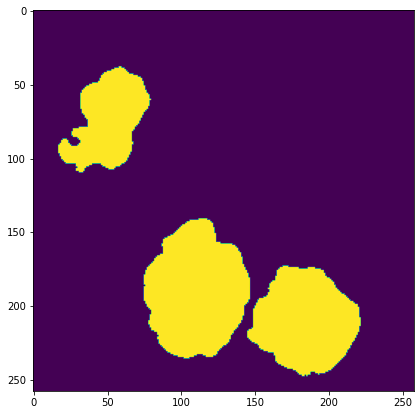

In [51]:
from tnia.morphology.fill_holes import fill_holes_3d_slicer
fill_holes_3d_slicer(binary)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(binary[65,:,:])

## Watershed

After thresholding some of the nuclei are toucing.  In this step we use 3D Watershed to split touching objects.  Separating object routines tend to be a 'recipe' with peak finding, distance map, and watershed steps.  The code used in this case can be found [here](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/tnia/segmentation/separate.py#L44)   

(5, 3)


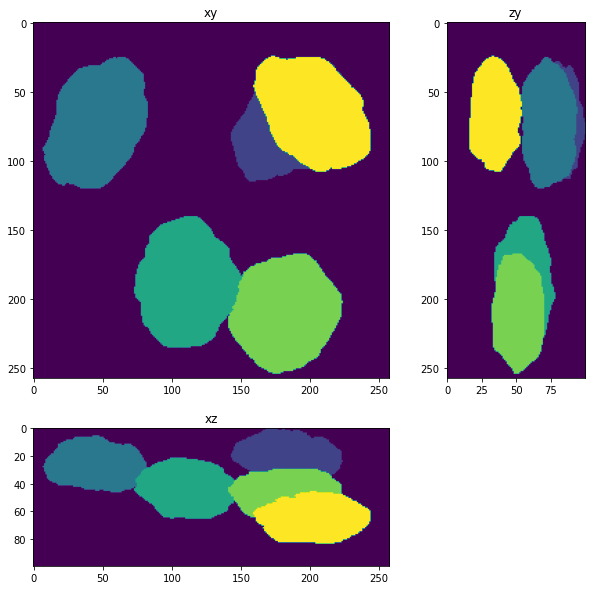

In [57]:
from skimage.transform import resize
from tnia.segmentation.separate import separate_touching2, separate_touching

labels,distance = separate_touching2(resized, binary, 5, [15,15,15],[5,5,5])
labels = resize(labels, [im_orig.shape[0],im_orig.shape[1], im_orig.shape[2]], preserve_range=True, order=0, anti_aliasing=False).astype('int32')
fig=show_xyz_max(labels)    

# 3D Visualization
It's easy to bring up the Napari 3D Viewer right from a notebook and take a look at inputs, results and intermediate steps

In [ ]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(im_decon, scale = [sz,sy,sz])
viewer.add_labels(labels.astype('int32'), scale = [sz,sy,sz])

## Data Table

At this step we create a data table.  We use a helper to compute the region properties of the objects in our labelling and return centroid, intensity and volume of the objects in a Pandas table.

In [43]:
from tnia.segmentation.pandas_helper import get_df_centroid_intensity_volume_3D
stats=get_df_centroid_intensity_volume_3D(labels, im_decon, sx, sy, sz)

stats.head()

,x,y,z,intensity,volume
0,20.967404,9.873032,4.549152,8.590300e+07,345.322919
1,6.907200,10.639381,5.885293,9.921165e+07,375.785646
2,14.521549,23.518101,8.890713,1.154779e+08,415.742492
3,22.821594,24.550776,9.922294,1.021065e+08,375.276759
4,25.035990,8.181050,13.156101,7.846584e+07,292.251497


## Plotting

At this point we have our data in a table and we can also use Pandas (and matplotlib) to create figure. It is not a very big table.  We'd need much more data to get significant statistics.  

<AxesSubplot:ylabel='Frequency'>

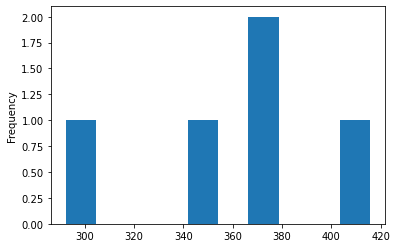

In [55]:
stats.volume.plot.hist()